In [4]:
!pip install -q -U immutabledict sentencepiece
!git clone https://github.com/google/gemma_pytorch.git
!mv /kaggle/working/gemma_pytorch/gemma/* /kaggle/working/gemma/

Cloning into 'gemma_pytorch'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 133 (delta 40), reused 35 (delta 23), pack-reused 68
Receiving objects: 100% (133/133), 2.15 MiB | 5.03 MiB/s, done.
Resolving deltas: 100% (67/67), done.
mv: target '/kaggle/working/gemma/' is not a directory


In [5]:
import re
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

In [6]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
import sys
sys.path.append("/kaggle/working/gemma_pytorch/") 
from gemma.config import get_config_for_7b, get_config_for_2b
from gemma.model import GemmaForCausalLM
from gemma.tokenizer import Tokenizer
import contextlib
import torch

In [8]:
import random
VARIANT = "2b-it" 
weights_dir = '/kaggle/input/gemma/pytorch/2b-it/2' 
device = 'cpu'
ckpt_path = f'{weights_dir}/gemma-{VARIANT}.ckpt'
def seed_everything(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.manual_seed(seed)
    random.seed(seed)
seed_everything(seed=2024)

In [9]:
model_config = get_config_for_2b() if "2b" in VARIANT else get_config_for_7b()

model_config.tokenizer = f"{weights_dir}/tokenizer.model"
print(f"model_config:{model_config}")


print(f"model_config.get_dtype():{model_config.get_dtype()}") 
@contextlib.contextmanager
def _set_default_tensor_type(dtype: torch.dtype):
    torch.set_default_dtype(dtype)
    yield
    torch.set_default_dtype(torch.float)
with _set_default_tensor_type(model_config.get_dtype()):
    model = GemmaForCausalLM(model_config)
    print("This is the model structure. : \n", model)
    model.load_weights(ckpt_path)
    print("Model weights loaded.")
    model = model.to(device).eval()
print("Model Configuraiton Done")

model_config:GemmaConfig(vocab_size=256000, max_position_embeddings=8192, num_hidden_layers=18, num_attention_heads=8, num_key_value_heads=1, hidden_size=2048, intermediate_size=16384, head_dim=256, rms_norm_eps=1e-06, dtype='bfloat16', quant=False, tokenizer='/kaggle/input/gemma/pytorch/2b-it/2/tokenizer.model')
model_config.get_dtype():torch.bfloat16
This is the model structure. : 
 GemmaForCausalLM(
  (embedder): Embedding()
  (model): GemmaModel(
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaAttention(
          (qkv_proj): Linear()
          (o_proj): Linear()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear()
          (up_proj): Linear()
          (down_proj): Linear()
        )
        (input_layernorm): RMSNorm()
        (post_attention_layernorm): RMSNorm()
      )
    )
    (norm): RMSNorm()
  )
  (sampler): Sampler()
)


/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Model weights loaded.
Model Configuraiton Done


In [10]:
def Ask_model(prompt):
    USER_CHAT_TEMPLATE = '{prompt}'
    MODEL_CHAT_TEMPLATE = '{prompt}'
    prompt = (
        USER_CHAT_TEMPLATE.format(
            prompt=prompt
        )
        + MODEL_CHAT_TEMPLATE.format(prompt="{prompt}")
    )
    output = model.generate(
    USER_CHAT_TEMPLATE.format(prompt=prompt),
    device=device)
    print('done')
    return output 
    
    

In [11]:
topics = [
    'Write a large document about pollution',
    'Write a large document about Inflation',
    'Write a large document about The unemployment',
    'Write a large document about Overpopulation'
] 

In [12]:
class preprocessing:
    def __init__(self,text):
        self.text=text
        self.words=None
    def clear(self):
        clean = re.compile('<.*?>')
        self.text =  re.sub(clean, '', self.text)
        self.text= re.sub(r"[^a-zA-Z]"," ",self.text)
        self.text = re.sub(r'\s+', ' ', self.text)
    def Normalization(self):
        self.text=self.text.lower()
        print(self.text)
    def Tokenization(self):
        self.words = word_tokenize(self.text)
        print(self.words)
    def del_stop_words(self):
        stop_words = set(stopwords.words('english'))
        self.words=[word for word in self.words if (word not in stop_words)]
    def stemming(self):
        stemmer = PorterStemmer()
        self.words = [stemmer.stem(word) for word in self.words]
    def unique_words(self):
        return set(self.words)
    def return_string(self):
        return ' '.join(self.words)
    def del_char (self):
        self.words=[word for word in self.words if (len(word)>1)]
        

In [13]:
def clean_document (document):
    cleaner = preprocessing(document)
    cleaner.clear()
    cleaner.Normalization()
    cleaner.Tokenization()
    cleaner.del_stop_words()
    cleaner.stemming()
    output = cleaner.return_string()
    return output 

In [14]:
documents = [Ask_model(topic) for topic in topics]

done
done
done
done


In [15]:
preprocessed_documents = [clean_document(document) for document in documents]

 pollution pollution refers to the introduction of harmful substances or practices into the environment that can have various negative impacts on human health the ecosystem and the environment sources of pollution include industrial emissions agricultural practices human settlements and natural sources environmental impacts of pollution pollution can have numerous adverse effects on the environment including air pollution air pollution can cause respiratory problems cardiovascular disease and other health issues it can also damage vegetation and reduce
['pollution', 'pollution', 'refers', 'to', 'the', 'introduction', 'of', 'harmful', 'substances', 'or', 'practices', 'into', 'the', 'environment', 'that', 'can', 'have', 'various', 'negative', 'impacts', 'on', 'human', 'health', 'the', 'ecosystem', 'and', 'the', 'environment', 'sources', 'of', 'pollution', 'include', 'industrial', 'emissions', 'agricultural', 'practices', 'human', 'settlements', 'and', 'natural', 'sources', 'environmental

In [16]:
preprocessed_documents[3]

'overpopul definit overpopul condit popul exce carri capac given environ term often use refer specif popul global popul whole caus overpopul malthusian factor includ high fertil rate low mortal rate limit access educ contracept econom factor includ high popul growth poverti lack'

In [17]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(preprocessed_documents)

In [18]:
feature_names = vectorizer.get_feature_names_out()
tfidf_weights = tfidf_matrix.toarray()

In [19]:
tfidf_weights

array([[0.        , 0.09766473, 0.        , 0.        , 0.09766473,
        0.        , 0.19532946, 0.09766473, 0.        , 0.        ,
        0.        , 0.        , 0.09766473, 0.        , 0.05096551,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.09766473, 0.        ,
        0.        , 0.        , 0.        , 0.09766473, 0.        ,
        0.        , 0.        , 0.09766473, 0.        , 0.09766473,
        0.09766473, 0.        , 0.23099998, 0.09766473, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.09766473, 0.19532946, 0.        , 0.19532946, 0.19532946,
        0.15399999, 0.        , 0.09766473, 0.        , 0.07699999,
        0.07699999, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.09

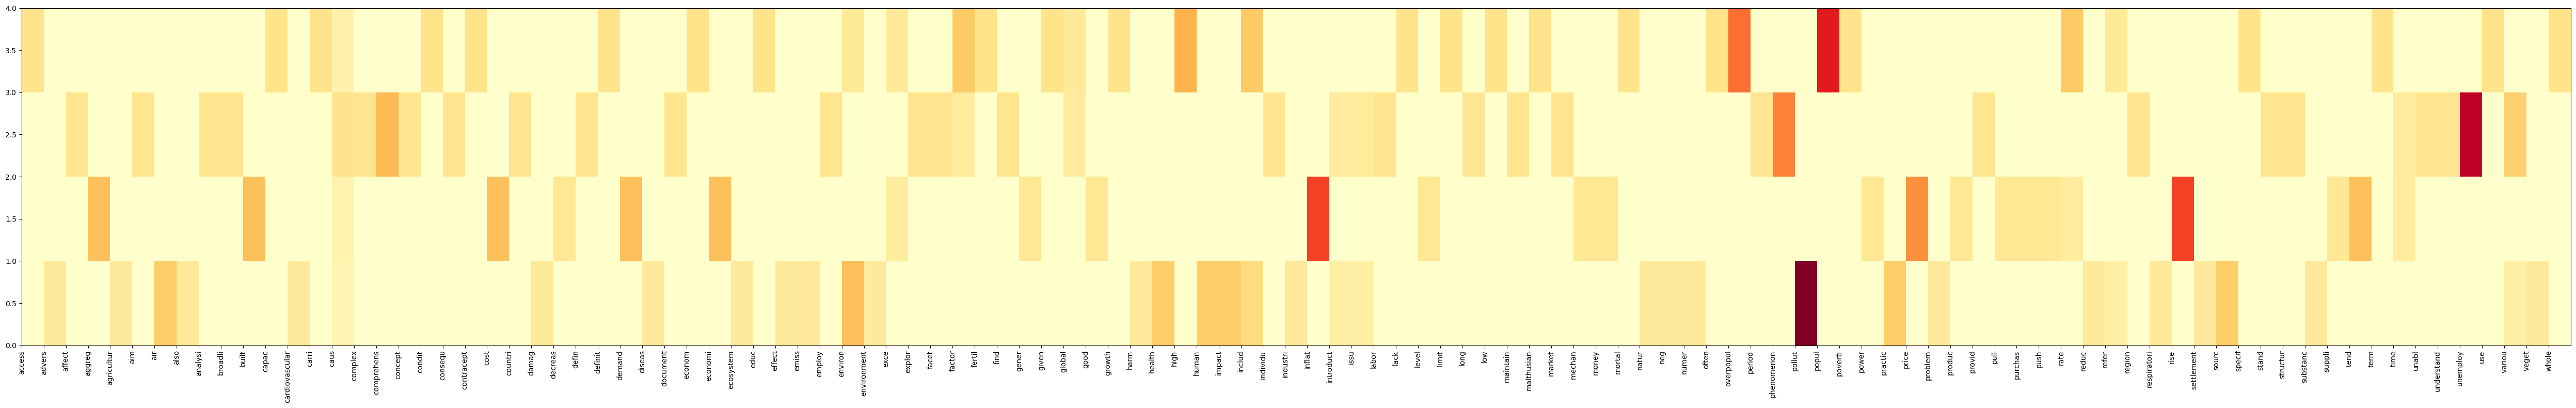

In [20]:
plt.figure(figsize=(50, 8))  # Adjust figure size as needed
plt.pcolormesh(tfidf_weights, cmap="YlOrRd")


plt.xticks(rotation=90)
plt.xticks(ticks=range(len(feature_names) ), labels=feature_names)


plt.tight_layout()  
plt.show()